<a href="https://colab.research.google.com/github/InMyDream21/Deep-Learning/blob/main/Tensorflow/zerotomastery/natural_language/SkimLit_NLP_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-21eae000-c1c2-b6c2-8a98-7fe744c4ee57)


## Get data

Since we'll be replicating the paper (PubMed 200k RCT), lets download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaces by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target diectory
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, Visualize, visualize

So with that in mind, lets write a function to read in all of the lines of a target text file.

In [6]:
# Create function to read the lines of a document
def get_line(filename):
  """
  Reads filename (a text file name) and returns the lines of text as a list.

  Args: 
    filename: a string containing the target filepath.

  Returns: 
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_line(data_dir + "train.txt") # Read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Lets think about how we want our data to look

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': BACKGROUND,
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstact line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in teh current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_line(filename) # Get all lines from filename
  abstract_lines = "" # CReate an empty abstract
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file

  for line in input_lines:
    if line.startswith("###"): # Check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # Reset the abstract string if the line is an ID line
    elif line.isspace(): # Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # SPlit abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # Split target label from text
        line_data["target"] = target_text_split[0] # Get target label
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number # What number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # How many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line to abstract samples list
    
    else: # If the above condition aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 438 ms, sys: 93.8 ms, total: 532 ms
Wall time: 533 ms


Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

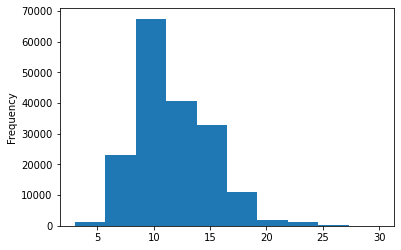

In [13]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them in to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying our a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes clasifier).

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(X = val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [22]:
val_labels_encoded[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

### Download helper function script

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-17 07:43:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-17 07:43:40 (47.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing out data (the text) for deep sequence model

Before we start building deeper models, we've got to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split())for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.338269273494777

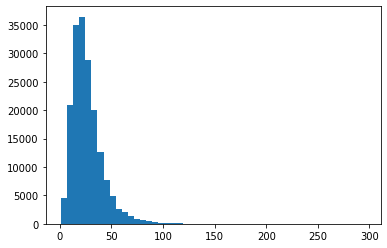

In [28]:
# Whats the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 50);

In [29]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text fro mwords to numbers.

In [31]:
# How many words are in out vocab
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, # Numbere of words in vocab
                                    output_sequence_length = output_seq_len,
                                    pad_to_max_tokens = True) # Desired output length of vectorized sequence

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
to observe the impacts on skeletal fluorosis pain , joint motor dysfunction and urine fluoride excretion in the treatment with fire needle therapy , electroacupuncture and calcium carbonate d@ .

Length of text: 194

Vectorized text: [[    6  1756     2  3136    18  2681 26518    65  1060   600   718     3
    943  2527  2471     5     2    19     7  5140  1347    66  2553     3
    826  5591   187     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20_text_vocab)}")
print(f"Most commong words in the vocab: {rct_20_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20_text_vocab[-5:]}")

Number of words in vocab: 64841
Most commong words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create a custom text embedding layer

In [37]:
# CReate token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20_text_vocab),
                               output_dim = 128,
                               mask_zero = True, # Use masking to handle variable sequence length
                               name = "token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 to observe the impacts on skeletal fluorosis pain , joint motor dysfunction and urine fluoride excretion in the treatment with fire needle therapy , electroacupuncture and calcium carbonate d@ .

Sentence after vectorization:
 [[    6  1756     2  3136    18  2681 26518    65  1060   600   718     3
    943  2527  2471     5     2    19     7  5140  1347    66  2553     3
    826  5591   187     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.01643423  0.04183291 -0.03246086 ... -0.01697391 -0.00571955
   -0.03711706]
  [-0.02012163 -0.01329724  0.04685659 ... -0.03441439 -0.00039947
    0.01295011]
  [ 0.01875288  0.02331698  0.02810634 ...  0.01362206 -0.03358473
   -0.04031861]
  ...
  [-0.00499635 -0.0198693  -0.01308137 ... -0.02743256 -0.04364897
   -0.03746971]
  [-0.00499635 -0.0198693  -0.013

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API.

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDatasets and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, 5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [43]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) # Only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9157 - accuracy: 0.6386 - val_loss: 0.6840 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6570 - accuracy: 0.7569 - val_loss: 0.6316 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6155 - accuracy: 0.7754 - val_loss: 0.5937 - val_accuracy: 0.7836


In [44]:
# Evaluate the model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5940 - accuracy: 0.7872


[0.5939871668815613, 0.7872037887573242]

In [45]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.65072423e-01, 1.65359363e-01, 5.63542955e-02, 2.87281543e-01,
         2.59324089e-02],
        [3.95290703e-01, 3.53376657e-01, 1.17628193e-02, 2.28748932e-01,
         1.08208805e-02],
        [1.42783493e-01, 6.56597223e-03, 2.70231534e-03, 8.47919106e-01,
         2.90675507e-05],
        [1.54351328e-05, 4.13778616e-04, 9.84307587e-01, 1.50991928e-05,
         1.52480453e-02],
        [1.06940453e-03, 3.91615629e-02, 2.96903282e-01, 8.62660410e-04,
         6.62003100e-01],
        [2.02490147e-02, 3.06035429e-02, 5.76414168e-01, 9.28072166e-03,
         3.63452554e-01],
        [5.04226889e-04, 4.63062385e-03, 2.91741788e-01, 2.57286534e-04,
         7.02866077e-01],
        [3.07066608e-02, 3.02896369e-02, 6.31582856e-01, 1.62503663e-02,
         2.91170537e-01],
        [7.79089900e-13, 3.12935988e-08, 2.69450027e-07, 3.09753416e-13,
         9.99999642e-01],
        [9.90063325e-03, 6.94665730e-01, 5.77384010e-02, 2.45123189e-02,
         2.13182941e-01]], dtype=flo

In [46]:
# COnvert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [47]:
# Calculate model_1 results 
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.72037600953263,
 'precision': 0.7837257883902207,
 'recall': 0.7872037600953263,
 'f1': 0.7844138028077136}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embedding. More specifically we're using the Universal Sentence Encoder.

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random Sentence:
 there is no benefit to adding a short video to the previously established improved readability and audiovisual supplementation .
Sentence after embedding:
 [ 0.04288513 -0.05134558  0.02095374 -0.07289219 -0.08188729  0.05843003
 -0.01931066  0.07469893  0.02448897  0.06651999  0.02088647  0.07203542
 -0.02185751  0.05200147 -0.02120764  0.06989586 -0.02310774 -0.0348451
 -0.07132298  0.03134206  0.03530257  0.0602991  -0.07320807  0.06724256
 -0.08244196  0.01015379  0.01873566 -0.03543239  0.02362772 -0.02434626]

Length of sentence embedding: 512


### Building and fitting an NLP Feature extractyion model using pretrained embeddings from TensorFlow Hub

In [50]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize text and create emebdding of each sequence
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
# Note: You could add more layers here if you wanted to
outputs = layers.Dense(5, activation = "softmax")(x) # Output layer
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# FIt model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9168 - accuracy: 0.6494 - val_loss: 0.7972 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7698 - accuracy: 0.6992 - val_loss: 0.7549 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7528 - accuracy: 0.7109 - val_loss: 0.7390 - val_accuracy: 0.7154


In [53]:
# EValuate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7416 - accuracy: 0.7136


[0.7415826320648193, 0.7135906219482422]

In [54]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[4.2993951e-01, 3.5259423e-01, 1.8719396e-03, 2.0916262e-01,
        6.4317132e-03],
       [3.1126043e-01, 5.3545141e-01, 3.1625140e-03, 1.4713717e-01,
        2.9884039e-03],
       [2.1913669e-01, 1.4660503e-01, 1.7521709e-02, 5.7442439e-01,
        4.2312276e-02],
       ...,
       [1.6796245e-03, 5.5877734e-03, 5.4566674e-02, 8.6892844e-04,
        9.3729705e-01],
       [4.4814763e-03, 5.1241454e-02, 2.0580068e-01, 1.6092024e-03,
        7.3686719e-01],
       [1.8696278e-01, 3.1545156e-01, 4.3542060e-01, 7.5468188e-03,
        5.4618187e-02]], dtype=float32)

In [55]:
# Make predictions classes
model_2_pred = tf.argmax(model_2_pred_probs, axis = 1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_pred)
model_2_results

{'accuracy': 71.35906262412286,
 'precision': 0.713825482790783,
 'recall': 0.7135906262412286,
 'f1': 0.7105822257322852}

## Model 3: Conv1D with character embeddings

### Create a character-level tokenizer

In [57]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [58]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e r e   i s   n o   b e n e f i t   t o   a d d i n g   a   s h o r t   v i d e o   t o   t h e   p r e v i o u s l y   e s t a b l i s h e d   i m p r o v e d   r e a d a b i l i t y   a n d   a u d i o v i s u a l   s u p p l e m e n t a t i o n   .'

In [59]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [60]:
# Whats the average character length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

149.3662574983337

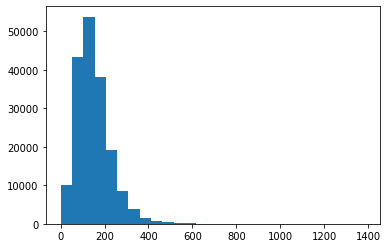

In [61]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins = 27);

In [62]:
# Find whats character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [63]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [64]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    pad_to_max_tokens = True,
                                    name = "char_vectorizer")

In [65]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [66]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most commong characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most commong characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
m o x i f l o x a c i n   i s   e f f e c t i v e   a n d   s a f e   f o r   t r e a t m e n t   o f   c o m m u n i t y - a c q u i r e d   p n e u m o n i a   w i t h   a s p i r a t i o n   f a c t o r s   .
Length of random_train_chars: 93
Vectorized chars:
 [[15  7 24  4 17 12  7 24  5 11  4  6  4  9  2 17 17  2 11  3  4 21  2  5
   6 10  9  5 17  2 17  7  8  3  8  2  5  3 15  2  6  3  7 17 11  7 15 15
  16  6  4  3 19  5 11 26 16  4  8  2 10 14  6  2 16 15  7  6  4  5 20  4
   3 13  5  9 14  4  8  5  3  4  7  6 17  5 11  3  7  8  9  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding 

In [68]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # Number of different characters
                              output_dim = 25,
                              name = "char_embed")

In [69]:
# TEst our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded text:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 m o x i f l o x a c i n   i s   e f f e c t i v e   a n d   s a f e   f o r   t r e a t m e n t   o f   c o m m u n i t y - a c q u i r e d   p n e u m o n i a   w i t h   a s p i r a t i o n   f a c t o r s   .

Embedded text:
 [[[-0.02477812 -0.0114848   0.02368461 ...  0.03802298  0.03091041
   -0.02388344]
  [-0.04874759 -0.045463    0.00309032 ...  0.03424213 -0.01482781
    0.03326407]
  [-0.01738684 -0.0353958  -0.03800289 ... -0.03261894 -0.01159998
   -0.04173955]
  ...
  [-0.00238433  0.00152272 -0.03831584 ...  0.00685036 -0.00748327
    0.00159314]
  [-0.00238433  0.00152272 -0.03831584 ...  0.00685036 -0.00748327
    0.00159314]
  [-0.00238433  0.00152272 -0.03831584 ...  0.00685036 -0.00748327
    0.00159314]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [70]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_conv1d_char_embeddings")

# COmpile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [71]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [72]:
len(val_chars), len(val_labels_one_hot)

(30212, 30212)

In [73]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2767 - accuracy: 0.4863 - val_loss: 1.0411 - val_accuracy: 0.5874
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9989 - accuracy: 0.6025 - val_loss: 0.9406 - val_accuracy: 0.6250
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9226 - accuracy: 0.6382 - val_loss: 0.8661 - val_accuracy: 0.6632


In [75]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

945/945 [==============================] - 2s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [76]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 65.77187872368594,
 'precision': 0.6498782558836989,
 'recall': 0.6577187872368595,
 'f1': 0.6472307010780985}

## Model 4: Combining pretrained token embeddings + characters embedding (hybrid)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model(similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [77]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi-LSTM
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,
                                   char_model.input],
                         outputs=[output_layer],
                         name = "model_4_token_and_char_embeddings")

In [78]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

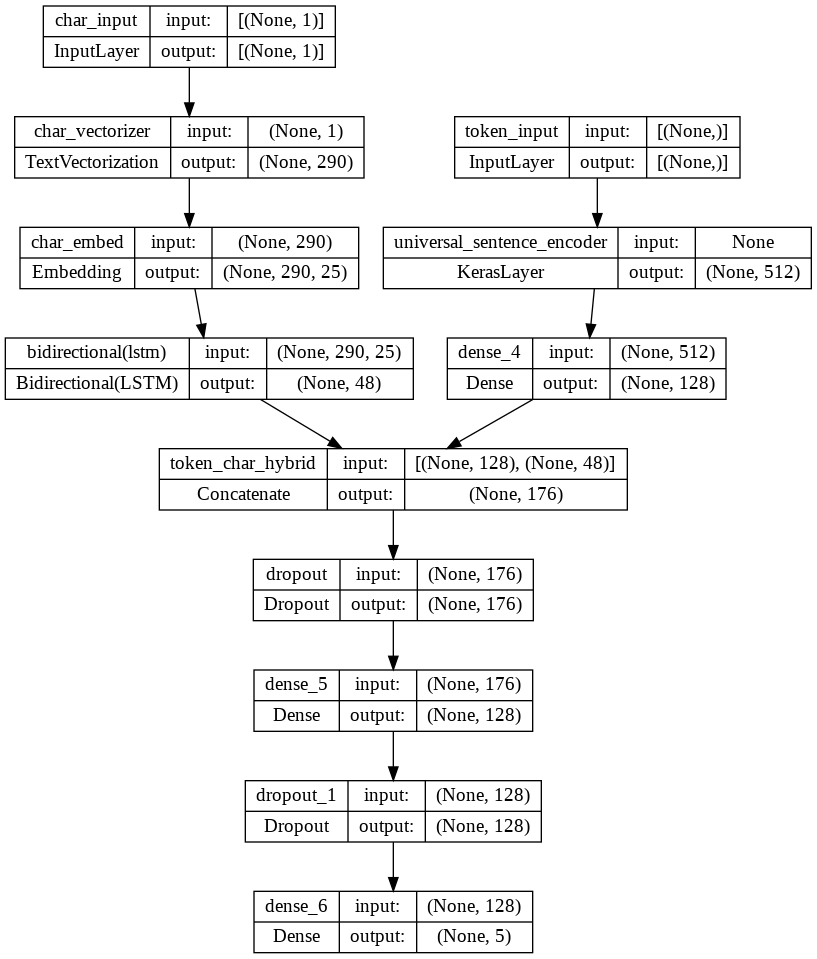

In [79]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [80]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [81]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine data and labels 

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# combine validation and test
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [83]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs = 3,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 24s 34ms/step - loss: 0.9953 - accuracy: 0.5997 - val_loss: 0.7950 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.8126 - accuracy: 0.6876 - val_loss: 0.7280 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7781 - accuracy: 0.7013 - val_loss: 0.6935 - val_accuracy: 0.7350


In [84]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6986 - accuracy: 0.7318


[0.6986274123191833, 0.7317953109741211]

In [85]:
# Make predictions using model 4
model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis = 1)

# Calculate results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

945/945 [==============================] - 19s 19ms/step


{'accuracy': 73.17953131206143,
 'precision': 0.7320979013501234,
 'recall': 0.7317953131206143,
 'f1': 0.7288341308736039}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [86]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings 

In [87]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

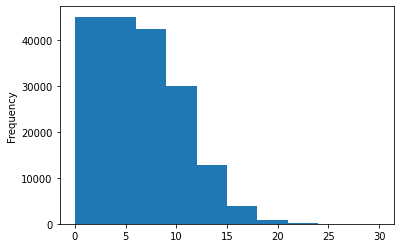

In [88]:
# Check the fistribution of line number column
train_df.line_number.plot.hist();

In [89]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15) 
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for out total lines number

In [90]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

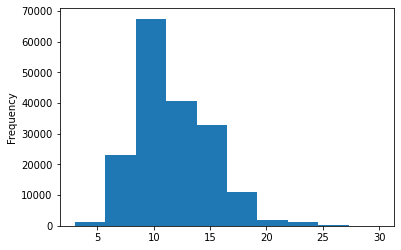

In [91]:
train_df.total_lines.plot.hist();

In [92]:
# Check the 95th percentile
np.percentile(train_df["total_lines"].to_numpy(), 95)

18.0

In [93]:
# Use TensorFlow one hot
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4, and outputs of 7 into a tf.keras.Model

In [94]:
train_total_lines_one_hot[0].dtype

tf.float32

In [95]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape = (1,), dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, name="lstm_layer"), name="bi-lstm_layer")(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line_number feature model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total_lines feature model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine the outputs of 3, 4, and 5 using layers.Concatenate
tribrid_embeddings = layers.Concatenate(name="char-token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create an output layers to accept the tribrid embedding and output label probabilities
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[token_inputs,
                                 char_inputs,
                                 line_number_inputs,
                                 total_lines_inputs],
                         outputs=output_layer, name="tribrid_embedding_model")

In [96]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

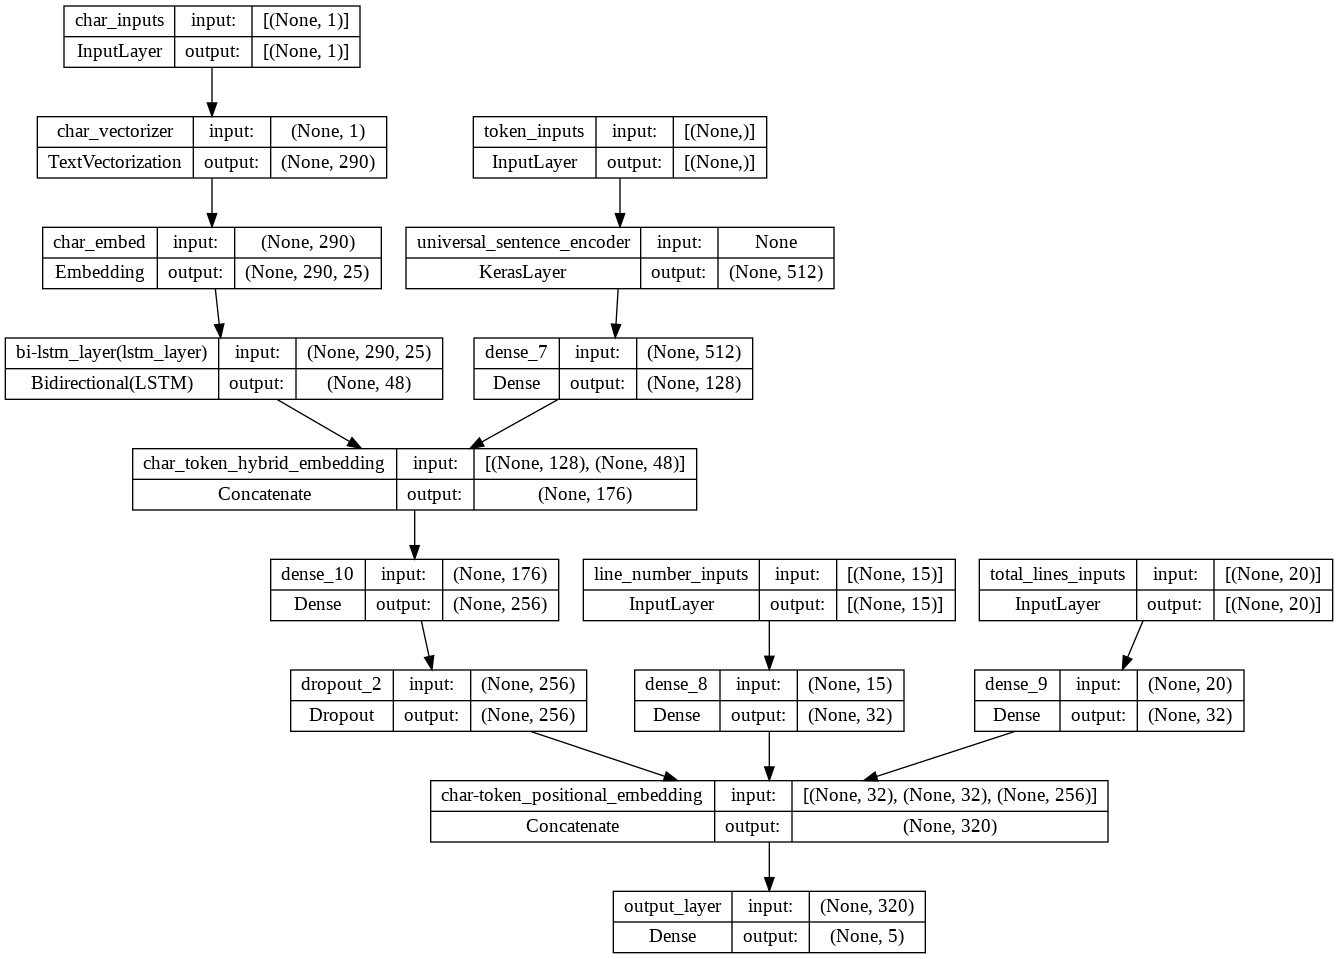

In [97]:
# Plot the model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example if our model gets too confident on a single class
(e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident = `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully imrpoving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [98]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [99]:
# Create training and validation dataset (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                train_chars, 
                                                                train_line_numbers_one_hot,
                                                                train_total_lines_one_hot))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                              val_chars,
                                                              val_line_numbers_one_hot,
                                                              val_total_lines_one_hot))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

In [100]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making prediction with our tribrid model

In [101]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 35ms/step - loss: 1.0979 - accuracy: 0.7210 - val_loss: 0.9870 - val_accuracy: 0.8052
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9710 - accuracy: 0.8126 - val_loss: 0.9522 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9519 - accuracy: 0.8230 - val_loss: 0.9409 - val_accuracy: 0.8278


In [102]:
# Make predictions wwith the char token pos model
model_5_preds = tf.argmax(model_5.predict(val_char_token_pos_dataset, verbose = 1), axis = 1)
model_5_preds

945/945 [==============================] - 24s 24ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [103]:
# make results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 83.07957103137826,
 'precision': 0.830070473644112,
 'recall': 0.8307957103137826,
 'f1': 0.830031277604379}

## Compare model results

In [104]:
# COmbine model results into a dataframe 
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1_custom_token": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token,78.720376,0.783726,0.787204,0.784414
model_2_pretrained_token_embedding,71.359063,0.713825,0.713591,0.710582
model_3_custom_char_embedding,65.771879,0.649878,0.657719,0.647231
model_4_hybrid_char_token_embedding,73.179531,0.732098,0.731795,0.728834
model_5_pos_char_token_embedding,83.079571,0.830070,0.830796,0.830031


In [105]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

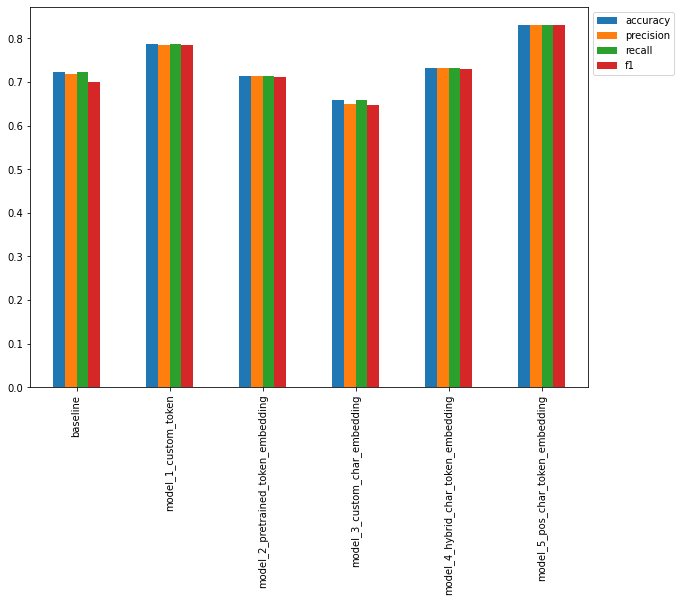

In [106]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

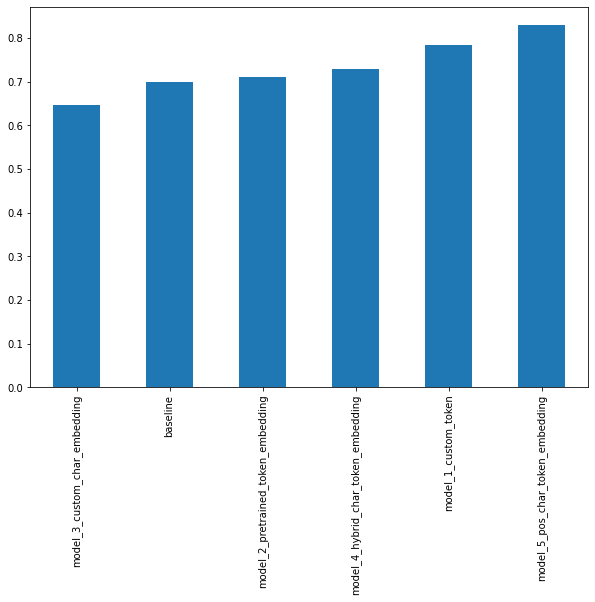

In [107]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model

In [108]:
# Save the best performing model to SavedModel format
model_5.save("skimlit_tribrid_model")

In [109]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("/content/skimlit_tribrid_model")

In [110]:
# Make prediction
loaded_model_preds = tf.argmax(loaded_model.predict(val_char_token_pos_dataset), axis=1)
loaded_model_preds

945/945 [==============================] - 20s 20ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_model_preds)
loaded_model_results

{'accuracy': 83.07957103137826,
 'precision': 0.830070473644112,
 'recall': 0.8307957103137826,
 'f1': 0.830031277604379}

In [112]:
assert loaded_model_results == model_5_results

In [113]:
model_5_results

{'accuracy': 83.07957103137826,
 'precision': 0.830070473644112,
 'recall': 0.8307957103137826,
 'f1': 0.830031277604379}